In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [90]:
# Load the dataset
data = pd.read_csv('Housing-1.csv')


In [91]:
# Preprocessing: Encode categorical features and scale numerical features
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                       'airconditioning', 'prefarea', 'furnishingstatus']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [92]:
# Separate features and target variable
X = data.drop('price', axis=1)
y = data['price']

In [93]:
# Standardize both features and target variable
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the preprocessed data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Define the dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [94]:
# Define the updated ANN model
class ANNRegressionModel(nn.Module):
    def __init__(self):
        super(ANNRegressionModel, self).__init__()
        self.fc1 = nn.Linear(X_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [95]:
# Function to train the model
def train_model(model, criterion, optimizer, dataloader, epochs=100):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}')

    return train_losses


In [96]:
# Initialize the model, loss function, and optimizer
model = ANNRegressionModel()
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate


In [97]:
# Train the model
train_losses = train_model(model, criterion, optimizer, dataloader, epochs=100)

Epoch 10/100, Loss: 0.6184
Epoch 20/100, Loss: 0.3172
Epoch 30/100, Loss: 0.2859
Epoch 40/100, Loss: 0.2939
Epoch 50/100, Loss: 0.3068
Epoch 60/100, Loss: 0.2464
Epoch 70/100, Loss: 0.2385
Epoch 80/100, Loss: 0.2361
Epoch 90/100, Loss: 0.2241
Epoch 100/100, Loss: 0.2056


In [98]:
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor).numpy()

In [99]:
# Revert the scaling for predictions and target
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_rescaled = scaler_y.inverse_transform(y_tensor.numpy())

In [100]:
# Calculate evaluation metrics
mse = mean_squared_error(y_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_rescaled, y_pred_rescaled)
r2 = r2_score(y_rescaled, y_pred_rescaled)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

MSE: 747837194240.0000
MAE: 616835.8125
R²: 0.7859


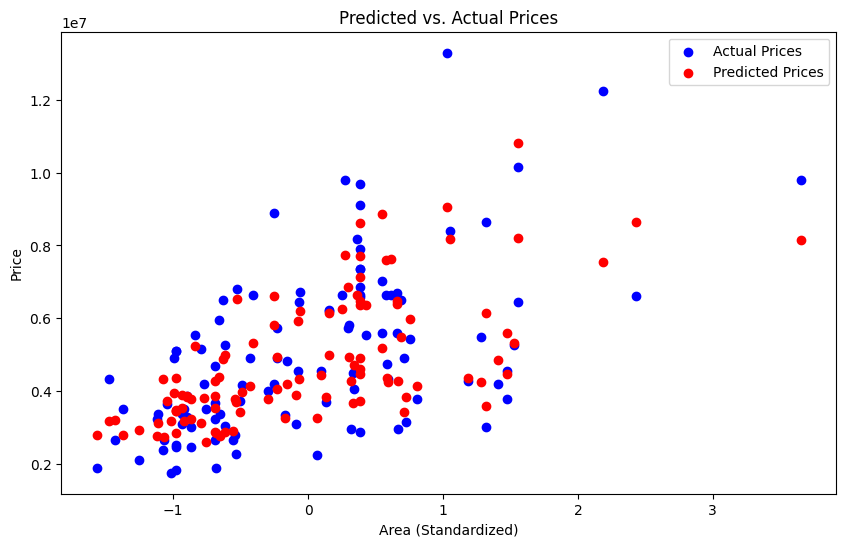

In [101]:
# Plot: Predicted vs. Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[:, 0], y_test_denorm, color='blue', label='Actual Prices')  # Area on X-axis
plt.scatter(X_test_scaled[:, 0], y_test_pred_denorm, color='red', label='Predicted Prices')
plt.xlabel('Area (Standardized)')
plt.ylabel('Price')
plt.legend()
plt.title('Predicted vs. Actual Prices')
plt.show()

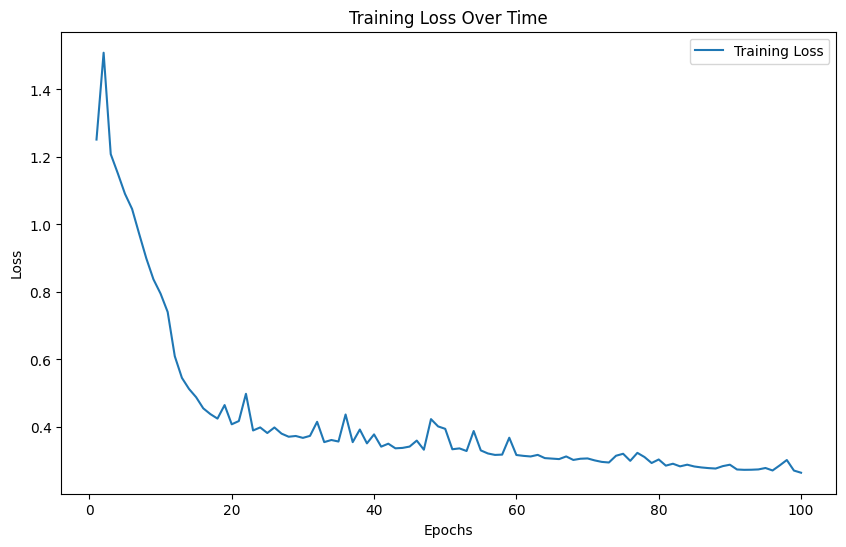

In [103]:
# Plot: Training Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()